# Gridding PFT variables to sparse arrays

This notebook explores regridding the PFT variables as sparse arrays using the `pydata/sparse` package.

Inspired by `PFT-Gridding.ipynb`

### Importing Libraries

In [1]:
%matplotlib inline

import numpy as np
import xarray as xr
from ctsm_py import utils

### Defining simulation information

In [2]:
datadir = "/glade/p/cgd/tss/people/dll/TRENDY2019_History/"
sim = "S0_control/"
datadir = datadir + sim
simname = "TRENDY2019_S0_control_v2.clm2.h1."
var = "GPP"
years = "170001-201812"

maxval = "True"

In [3]:
print(datadir + simname + var + "." + years + ".nc")

/glade/p/cgd/tss/people/dll/TRENDY2019_History/S0_control/TRENDY2019_S0_control_v2.clm2.h1.GPP.170001-201812.nc


In [4]:
# This is an example copied from Dan's script -- helps to read in multiple variables
# dir =
# sim =
# pref = 'lnd/proc/tseries/month_1'
# suff = ".clm2.h0."
# variables = [" "]
# pattern   = dir + sim + proc + pref + '{var}' + suff
# files = [pattern.format(var=var) for var in variables]

# for multiple files, use xr.open_mfdataset; dan also uses utils.time_set_mid to make the time dims work properly

# 365*utils.weighted_annual_mean --> weights by days/month
# timeslice: ix_time = (ds['time.year']>1963) & (ds['time.year']<2014) # note that dan's dataset is 'ds'
# plt.subplot(121) #-->1 row, 2 plots, plot 1
# signal.detrend (?)

In [5]:
data1 = utils.time_set_mid(
    xr.open_dataset(
        datadir + simname + var + "." + years + ".nc",
        decode_times=True,
        chunks={"time": 100},
    ),
    "time",
)
data1

<xarray.Dataset>
Dimensions:             (levgrnd: 25, levlak: 10, levdcmp: 25, lon: 288, lat: 192, gridcell: 21013, landunit: 48359, column: 111429, pft: 166408, time: 3828, hist_interval: 2)
Coordinates:
  * levgrnd             (levgrnd) float32 0.01 0.04 0.09 ... 19.48 28.87 42.0
  * levlak              (levlak) float32 0.05 0.6 2.1 4.6 ... 25.6 34.33 44.78
  * levdcmp             (levdcmp) float32 0.01 0.04 0.09 ... 19.48 28.87 42.0
  * lon                 (lon) float32 0.0 1.25 2.5 3.75 ... 356.2 357.5 358.8
  * lat                 (lat) float32 -90.0 -89.06 -88.12 ... 88.12 89.06 90.0
  * time                (time) object 1700-01-16 11:44:59.999993 ... 2018-12-...
Dimensions without coordinates: gridcell, landunit, column, pft, hist_interval
Data variables: (12/51)
    area                (lat, lon) float32 dask.array<chunksize=(192, 288), meta=np.ndarray>
    landfrac            (lat, lon) float32 dask.array<chunksize=(192, 288), meta=np.ndarray>
    landmask            (lat, lon) float64 dask.array<chunksize=(192, 288), meta=np.ndarray>
    pftmask             (lat, lon) float64 dask.array<chunksize=(192, 288), meta=np.ndarray>
    nbedrock            (lat, lon) float64 dask.array<chunksize=(192, 288), meta=np.ndarray>
    grid1d_lon          (gridcell) float64 dask.array<chunksize=(21013,), meta=np.ndarray>
    ...                  ...
    mscur               (time) float64 dask.array<chunksize=(100,), meta=np.ndarray>
    nstep               (time) float64 dask.array<chunksize=(100,), meta=np.ndarray>
    time_bounds         (time, hist_interval) object dask.array<chunksize=(100, 2), meta=np.ndarray>
    date_written        (time) object dask.array<chunksize=(100,), meta=np.ndarray>
    time_written        (time) object dask.array<chunksize=(100,), meta=np.ndarray>
    GPP                 (time, pft) float32 dask.array<chunksize=(100, 166408), meta=np.ndarray>
Attributes: (12/102)
    title:                                     CLM History file information
    comment:                                   NOTE: None of the variables ar...
    Conventions:                               CF-1.0
    history:                                   created on 09/27/19 16:25:57
    source:                                    Community Terrestrial Systems ...
    hostname:                                  cheyenne
    ...                                        ...
    cft_irrigated_tropical_corn:               62
    cft_tropical_soybean:                      63
    cft_irrigated_tropical_soybean:            64
    time_period_freq:                          month_1
    Time_constant_3Dvars_filename:             ./TRENDY2019_S0_constant_v2.cl...
    Time_constant_3Dvars:                      ZSOI:DZSOI:WATSAT:SUCSAT:BSW:H...

### Convert the 1D PFT dataarrays to nD sparse arrays


In [35]:
def to_sparse(data, vegtype, jxy, ixy, shape):
    """ Takes an input numpy array and converts it to a sparse array."""
    import itertools

    import sparse

    codes = zip(vegtype, jxy - 1, ixy - 1)

    # some magic from https://github.com/pydata/xarray/pull/5577
    # This constructs a list of coordinate locations at which data exists
    # it works for arbitrary number of dimensions but assumes that the last dimension
    # is the "stacked" dimension i.e. "pft"
    if data.ndim == 1:
        indexes = codes
    else:
        sizes = list(itertools.product(*[range(s) for s in data.shape[:-1]]))
        tuple_indexes = itertools.product(sizes, codes)
        indexes = map(lambda x: list(itertools.chain(*x)), tuple_indexes)

    return sparse.COO(
        coords=np.array(list(indexes)).T,
        data=data.ravel(),
        shape=data.shape[:-1] + shape,
    )


def convert_pft_variables_to_sparse(dataset):
    import sparse
    import xarray as xr

    # extract PFT variables
    pfts = xr.Dataset({k: v for k, v in dataset.items() if "pft" in v.dims})

    ixy = dataset.pfts1d_ixy.astype(int)
    jxy = dataset.pfts1d_jxy.astype(int)
    vegtype = dataset.pfts1d_itype_veg.astype(int)
    npft = vegtype.max().load().item()
    # expected shape of sparse arrays (excludes time)
    output_sizes = {
        "pft": npft + 1,
        "lat": dataset.sizes["lat"],
        "lon": dataset.sizes["lon"],
    }

    result = xr.Dataset()
    for var in pfts:
        result[var] = xr.apply_ufunc(
            to_sparse,
            pfts[var],
            vegtype,
            jxy,
            ixy,
            input_core_dims=[["pft"]] * 4,
            output_core_dims=[["pft", "lat", "lon"]],
            exclude_dims=set(("pft",)),  # changes size
            dask="parallelized",
            kwargs=dict(shape=tuple(output_sizes.values())),
            dask_gufunc_kwargs=dict(
                meta=sparse.COO([]),
                output_sizes=output_sizes,
            ),  # lets dask know that we are changing from numpy to sparse
            output_dtypes=[pfts[var].dtype],
        )

    # copy over coordinate variables lat, lon
    result = result.update(dataset[["lat", "lon"]])
    result["pft"] = np.arange(result.sizes["pft"])
    return result

In [36]:
pfts = convert_pft_variables_to_sparse(data1)
pfts

<xarray.Dataset>
Dimensions:             (lat: 192, lon: 288, pft: 78, time: 3828)
Coordinates:
  * lat                 (lat) float64 -90.0 -89.06 -88.12 ... 88.12 89.06 90.0
  * lon                 (lon) float64 0.0 1.25 2.5 3.75 ... 356.2 357.5 358.8
  * time                (time) object 1700-01-16 11:44:59.999993 ... 2018-12-...
  * pft                 (pft) int64 0 1 2 3 4 5 6 7 ... 70 71 72 73 74 75 76 77
Data variables: (12/15)
    pfts1d_lon          (pft, lat, lon) float64 dask.array<chunksize=(78, 192, 288), meta=np.ndarray>
    pfts1d_lat          (pft, lat, lon) float64 dask.array<chunksize=(78, 192, 288), meta=np.ndarray>
    pfts1d_ixy          (pft, lat, lon) float64 dask.array<chunksize=(78, 192, 288), meta=np.ndarray>
    pfts1d_jxy          (pft, lat, lon) float64 dask.array<chunksize=(78, 192, 288), meta=np.ndarray>
    pfts1d_gi           (pft, lat, lon) float64 dask.array<chunksize=(78, 192, 288), meta=np.ndarray>
    pfts1d_li           (pft, lat, lon) float64 dask.array<chunksize=(78, 192, 288), meta=np.ndarray>
    ...                  ...
    pfts1d_wtcol        (pft, lat, lon) float64 dask.array<chunksize=(78, 192, 288), meta=np.ndarray>
    pfts1d_itype_veg    (pft, lat, lon) float64 dask.array<chunksize=(78, 192, 288), meta=np.ndarray>
    pfts1d_itype_col    (pft, lat, lon) float64 dask.array<chunksize=(78, 192, 288), meta=np.ndarray>
    pfts1d_itype_lunit  (pft, lat, lon) float64 dask.array<chunksize=(78, 192, 288), meta=np.ndarray>
    pfts1d_active       (pft, lat, lon) float64 dask.array<chunksize=(78, 192, 288), meta=np.ndarray>
    GPP                 (time, pft, lat, lon) float64 dask.array<chunksize=(100, 78, 192, 288), meta=np.ndarray>

### test out a plot


xarray cannot handle directly plotting a sparse variable (yet). This  will be fixed soon; instead we manually "densify" to a numpy array using `.copy(data=gpp.data.todense())`

In [31]:
gpp = pfts.GPP.isel(time=3606).compute()
gpp = gpp.copy(data=gpp.data.todense())

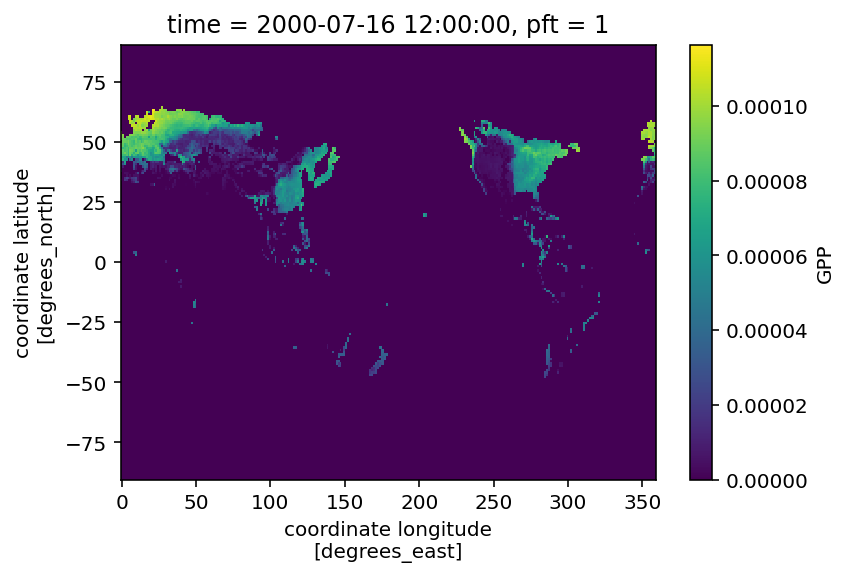

In [32]:
gpp.isel(pft=1).plot()